Enter the following before running the below simulation code:

tbin= the time interval for binning the number of molecules simulated in more than one run(recommended value = 0.1)

MR= list of sublists with each sublist containing rate constant of each reaction followed by negative of stoichiometric coeffecient of each component in reactant side of the particular reaction(in order)

MP=list of sublists with each sublist containing stoichiometric coeffecient of each component in the product side of the particular reaction(in order)

eg.
$X_1 → X_2$ (reaction 1 with rate constant= k1)

$2X_1 → X_3$ (reaction 2 with rate constant= k2)

MR=[[k1,-1,0,0],[k2,-2,0,0]]

MP=[[0,1,0],[0,0,1]]

    
xvalues=list with initial number of molecules of each component

tint=time interval between consecutive printouts of numbers of molecules in a particular time(recommended value=0.045)

$t_2$=time at which simulation ends

R=total number of simulation runs to be performed (R=1 is suffecient(and therefore recommended) for the simple systems under study)


Run the import and definition codes before running the simulation code

In [ ]:
#import code
import matplotlib.pyplot as plt
import math
import numpy as np

In [ ]:
#definition code

#bigtmatrix= list of lists containing time values chosen over all gillespie runs
#bigXmatrix= 3d matrix(list of list of list) with X values of all components(time) over all gillespie runs

#avgtlist-list of time points binned into tbin over all runs
def avgtlist(r,tbin):
  thelist=[]
  tau=0
  smallbintlist=[]
  for eta in bigtmatrix[r] :
    if tau<=eta and eta < tau+tbin:
      smallbintlist.append(eta)
    else:
      thelist.append((np.sum(smallbintlist)/len(smallbintlist)))
      smallbintlist=[]
      smallbintlist.append(eta)
      tau=tau+tbin
  return(thelist)

#averageXirlist= list of X values of component i in the rth gillespie run, binned into tbin
def averageXirlist(i,r,tbin):
  combinedXirlist=[]
  averagexlist=[]
  averagetlist=[]
  for j in range(len(bigXmatrix[r][i])):
    combinedXirlist.append([bigXmatrix[r][i][j],bigtmatrix[r][j]])
  time=0
  smallbinTlist=[]
  smallbinxlist=[]
  for xt in combinedXirlist:
    if time<=xt[1] and xt[1]<time+tbin:
      smallbinTlist.append(xt[1])
      smallbinxlist.append(xt[0])
    else:
      averagetlist.append(sum(smallbinTlist)/len(smallbinTlist))
      averagexlist.append(sum(smallbinxlist)/len(smallbinxlist))
      smallbinTlist=[]
      smallbinxlist=[]
      smallbinTlist.append(xt[1])
      smallbinxlist.append(xt[0])
      time=time+tbin
  return(averagexlist)

#gillespie_trial=function to run a single gillespie algorithm simulation

def gillespie_trial(MR,MP,xvalues,t2,tint):
  t=0
  #n=number of components
  n=len(xvalues)
  tprint=0
  tlist=[0]
  #alist=list of a values for the reactions
  alist=[]
  #Xvaluematrix=n lists of X values(number of molecules) obtained from simulation over time
  Xvaluematrix=[]
  for i in range(n):
  #creating empty list for each X in Xvaluematrix
    Xvaluematrix.append([xvalues[i]])
  alist=[]
  #running the simulation until stopping time t2
  while t<=t2:
   alist=[]
   for i in range(len(MR)):
    miarray=np.array(MR[i])
    #L_j[i] returns the positions in MR[i](denotes ith reaction) that participate in ith reaction with molecularity=j
    L_1=np.where(miarray==-1)
    L_2=np.where(miarray==-2)
    L_3=np.where(miarray==-3)
    #assigning ai if i is 1st reaction :
    if L_1[0].size>0 and L_2[0].size==0 and L_3[0].size==0 :
     mol=L_1[0].size
     ai=MR[i][0]
     for j in range(mol):
      ai=ai*xvalues[L_1[0][j]-1]
     alist.append(ai)
    #assigning ai if i is 2nd order reaction :
    if L_1[0].size==0 and L_2[0].size>0 and L_3[0].size==0 :
     alist.append(0.5*MR[i][0]*xvalues[L_2[0][0]-1]*(xvalues[L_2[0][0]-1]-1))
    #assigning ai if i is 3rd order reaction :
    if L_1[0].size==0 and L_2[0].size==0 and L_3[0].size>0 :
     alist.append((MR[i][0]/6)*xvalues[L_3[0][0]-1]*(xvalues[L_3[0][0]-1]-1)*(xvalues[L_3[0][0]-1]-2))
    #assigning ai if i is first order with respect to one component and second order with respect to another :
    if L_1[0].size>0 and L_2[0].size>0 and L_3[0].size==0 :
     alist.append(0.5*MR[i][0]*xvalues[L_1[0][0]-1]*xvalues[L_2[0][0]-1]*(xvalues[L_2[0][0]-1]-1))
    #assigning ai if i is zero order reaction
    if L_1[0].size==0 and L_2[0].size==0 and L_3[0].size==0 :
     alist.append(MR[i][0])
   aarray=np.array(alist)
   #a0=sum of a values of all reactions
   a0=np.sum(aarray)
   #choosing random numbers r1 for time evolution and r2 for reaction choosing
   r1=np.random.uniform(0,1)
   r2=np.random.uniform(0,1)
   #time evolution step
   t=t+((1/a0)*math.log(1/r1))
   tlist.append(t)
   #command to print X values
   if t>=tprint:
    print(f"X values are {xvalues} at time t={t}")
    tprint=tprint+tint
   #reaction choosing, the reaction that is chosen is assigned as m
   r2a0=r2*a0
   sum=0
   for nu,a in enumerate(alist):
    sum=sum+a
    if sum>=r2a0:
     m=nu
     break
   #updating the change in X values given that reaction m has taken place
   for j in range(n):
    xvalues[j] = xvalues[j] + MR[m][j+1] + MP[m][j]
   for i in range(n):
    Xvaluematrix[i].append(xvalues[i])
  print(f"X values at stopping time t2={t2} is {xvalues}")
  #plotting the X values v/s t for the particular gillespie simulation run
  for i in range(n):
   plt.plot(tlist,Xvaluematrix[i],label='Component'+str(i+1))
   plt.legend()
  plt.show()
  print(f"{len(Xvaluematrix[0])} is the number of sample times" )
  #bigtmatrix= list of lists containing time values chosen over all gillespie runs
  #appending the t list of this paticular gillespie run into bigtmatrix
  bigtmatrix.append(tlist)
  #bigXmatrix= 3d matrix(list of list of list) with X values of all components(time) over all gillespie runs
  #appending the Xvalue matrix for this particular gillespie run into bigXmatrix
  bigXmatrix.append(Xvaluematrix)
  #end



X values are [1000, 0, 0, 0] at time t=0.0004957175160898611
X values are [831, 163, 5, 1] at time t=0.045337965441120544
X values are [682, 279, 36, 3] at time t=0.0901652663807216
X values are [611, 324, 45, 20] at time t=0.1351277169344085
X values are [559, 348, 62, 31] at time t=0.18001426024192002
X values are [509, 364, 81, 46] at time t=0.2253307960720209
X values are [513, 332, 97, 58] at time t=0.27008107080458066
X values are [464, 361, 97, 78] at time t=0.3150045208568627
X values are [452, 349, 122, 77] at time t=0.36001017578589883
X values are [432, 344, 117, 107] at time t=0.40521361431796654
X values are [421, 326, 146, 107] at time t=0.45009407438103094
X values are [390, 346, 147, 117] at time t=0.495239837992737
X values are [390, 319, 125, 166] at time t=0.5402500712736201
X values are [392, 297, 141, 170] at time t=0.5851454156362259
X values are [372, 288, 172, 168] at time t=0.6300144879027114
X values are [369, 272, 189, 170] at time t=0.675124326771217
X value

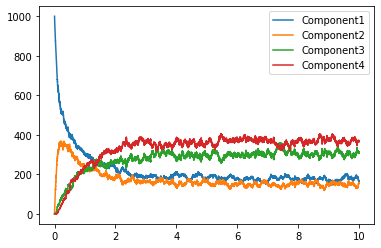

75503 is the number of sample times
1
1
100
100
100
100


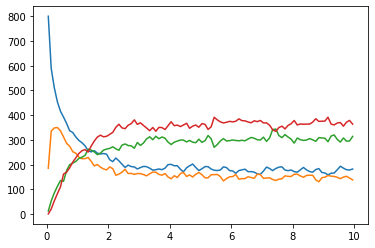

In [ ]:
#full code

#shown below is a demo code for kinetic and thermodynamic controlled reaction-2nd component(here,reactant) can reversibly and simultaneously convert to 1st and 3rd component.
#1st component-kinetically controlled product, 3rd component-thermodynmically controlled product
#please skip to bottom-most to see averaged plot

tbin=0.1
#MR=[[4,0,-1,0],[2,-1,0,0],[3,0,-1,0],[1,0,0,-1]]
#MP=[[1,0,0],[0,1,0],[0,0,1],[0,1,0]]
xvalues=[1000,0,0,0]

#SSA
#MR=[[1,-1,0,0],[1,0,-1,0]]
#MP=[[0,1,0],[0,0,1]]

#RDS
MR=[[6,-1,0,0,0],[7,0,-1,0,0],[2,0,-1,0,0],[1,0,0,-1,0],[8,0,0,-1,0],[6.5,0,0,0,-1]]
MP=[[0,1,0,0],[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]

tint=0.045
t2=10
R=1
r=1
n=len(xvalues)
bigtmatrix=[]
bigXmatrix=[]
while r<=R:
  gillespie_trial(MR,MP,xvalues,t2,tint)
  #print(tlist)
  xvalues=[1000,0,0,0]
  r=r+1
print(len(bigXmatrix))
print(len(bigtmatrix))
newXvaluematrix=[]
newstdevmatrix=[]
for k in range(n):
  newXvaluematrix.append([])
for b in range(n):
  for g in range(R):
    print(len(averageXirlist(b,g,tbin)))
for l in range(n):
  for j in range(len(avgtlist(0,tbin))):
    ravg=[]
    d=1
    while d<=R:
      ravg.append(averageXirlist(l,d-1,tbin)[j])
      d=d+1
    newXvaluematrix[l].append(sum(ravg)/len(ravg))
for m in range(n):
  plt.plot(avgtlist(0,tbin),newXvaluematrix[m])




